# Проект для ООО «Так закаляем сталь»

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Описание технологического процесса и исходных данных

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Содержание**

1. [Предобработка и исследовательский анализ данных](#preprocessing)
    
    1.1. [Результаты измерения температур](#data_temp)
    
    1.2. [Данные об электродах и продувке сплава газом](#arc_gas)
    
    1.3. [Данные о подаче сыпучих и проволочных материалов](#bulk_wire)
    
    1.4. [Объединение данных в единый датасет](#join)
    
    1.5. [Работа с выбросами](#outliers)
    
    1.6. [Корреляция признаков](#correlation)
   
   
2. [Обучение моделей, выбор лучшей модели](#models)

    2.2. [Подготовка данных к машинному обучению](#pre_ML)
    
    2.3. [Модель линейной регрессии с регуляризацией (Lasso)](#lasso)
    
    2.4. [Модель случайного леса (Random Forest)](#random_forest)
    
    2.5. [Модель градиентного бустинга (LightGBM)](#lgbm)
    
    2.6. [Модель градиентного бустинга (Catboost)](#catboost)
    
    2.7. [Сравнение моделей и выбор лучшей модели](#best_model)


3. [Выводы по проекту](#summary)

# Предобработка и исследовательский анализ данных<a id="preprocessing"></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Результаты измерения температур<a id = 'data_temp'>

Изучим файл с целевым признаком:

In [2]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp.head(12)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Убедимся, что наблюдения отсортированы по времени в возрастающем порядке. Это важно, поскольку нам нужно будет предсказать последнее измерение температуры в каждой партии.

In [3]:
data_temp['Время замера'].is_monotonic

False

In [4]:
data_temp = data_temp.sort_values(by = 'Время замера', ascending = True)

In [5]:
data_temp['Время замера'].is_monotonic

True

Изучим общую информацию о датасете:

In [6]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 497.1+ KB


Как видим, в таблице много пропусков в столбце со значениями температур.

Стоит уточнить у заказчика, из-за чего возникают пропуски в данных. По технологии температура должна замеряться в начале процесса обработки и после каждой итерации. Либо температура не измерялась, либо по какой-то причине показатели не сохранились. В любом случае, эту ошибку желательно исправить. 

Предоставим заказчику данные о партиях и времени замеров, где данные о температуре отсутствуют.

In [7]:
nans = data_temp[data_temp['Температура'].isna()]
# nans.to_csv('Данные об измерениях с отсутствующими значениями температур.csv')

Пропуски в столбце с целевым признаком недопустимы; пока заменим их нулями, а после анализа удалим:

In [8]:
data_temp = data_temp.fillna(0)

Приведем даты к формату Datetime, а значения температур - к целочисленному формату:

In [9]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp['Температура'] = data_temp['Температура'].astype('int')

Проверим, нет ли в файле дублей:

In [10]:
data_temp.duplicated().sum()

0

Сгруппируем данные по партиям и изучим распределение признаков. 

Сколько итераций в среднем приходится на одну партию?

In [11]:
data_temp.groupby('key')['Время замера'].count().describe()

count    3216.000000
mean        4.946206
std         1.793169
min         1.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        16.000000
Name: Время замера, dtype: float64

Количество партий в датасете - 3216.

Первый замер температуры делается до ввода легирующих добавок. 

Затем температура замеряется после каждой итерации, до достижения целевого химического состава и оптимальной температуры плавки. 

Количество замеров температуры в одной партии варьируется от 1 до 16, в среднем - 5. То есть в среднем каждая партия проходит через 4 итерации. 

Есть партии, для которых представлены данные только об одном замере. Это может означать, что обработка не производилась либо произошел сбой на этапе измерения или сохранения данных. Стоит уточнить у специалистов, с чем это связано. Мы удалим эти данные из датасета; они не помогут в обучении модели.

Изучим первый и последний замеры температуры, а также выведем общее количество замеров.

In [12]:
temp = data_temp.groupby('key').agg({'Температура': ['first', 'last', 'count']}).reset_index()
temp.columns = ['key', 'first_temp', 'last_temp', 'iters']
temp

,key,first_temp,last_temp,iters
0,1,1571,1613,5
1,2,1581,1602,6
2,3,1596,1599,5
3,4,1601,1625,3
4,5,1576,1602,2
...,...,...,...,...
3211,3237,1569,0,5
3212,3238,1584,0,3
3213,3239,1598,0,8
3214,3240,1617,0,8


Удалим отсутствующие значения, которые мы заменили на нули, а также партии с одним измерением температуры.

In [13]:
temp[(temp.last_temp == 0) | (temp.first_temp == 0) | (temp.iters == 1)]

,key,first_temp,last_temp,iters
192,195,1583,1583,1
276,279,1603,1603,1
2477,2500,1539,0,4
2478,2501,1587,0,5
2479,2502,1583,0,7
...,...,...,...,...
3211,3237,1569,0,5
3212,3238,1584,0,3
3213,3239,1598,0,8
3214,3240,1617,0,8


Таких партий много: 741 (23% от общего количества партий в датасете).

In [14]:
temp.drop(temp[(temp['last_temp'] == 0) | (temp['first_temp'] == 0) | (temp['iters'] == 1)].index, inplace = True)
temp

,key,first_temp,last_temp,iters
0,1,1571,1613,5
1,2,1581,1602,6
2,3,1596,1599,5
3,4,1601,1625,3
4,5,1576,1602,2
...,...,...,...,...
2472,2495,1570,1591,3
2473,2496,1554,1591,4
2474,2497,1571,1589,2
2475,2498,1591,1594,5


Чтобы получить верное количество итераций, уменьшим значения в столбце `iters` на единицу (по технологии первое измерение производится до начала обработки):

In [15]:
temp['iters'] = temp['iters'] - 1
temp

,key,first_temp,last_temp,iters
0,1,1571,1613,4
1,2,1581,1602,5
2,3,1596,1599,4
3,4,1601,1625,2
4,5,1576,1602,1
...,...,...,...,...
2472,2495,1570,1591,2
2473,2496,1554,1591,3
2474,2497,1571,1589,1
2475,2498,1591,1594,4


Изучим распределение данных в столбцах с первым и последним измерениями температур:

In [16]:
temp.first_temp.describe()

count    2475.000000
mean     1588.402020
std        29.243044
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: first_temp, dtype: float64

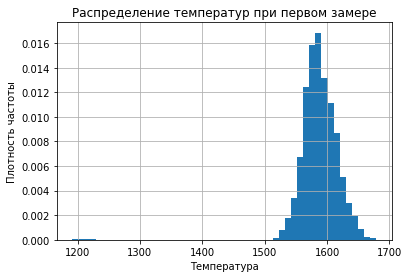

In [17]:
temp.first_temp.hist(density = True, bins = 50)
plt.title('Распределение температур при первом замере')
plt.xlabel('Температура')
plt.ylabel('Плотность частоты');

Значения температуры стали во время первого измерения распределены нормально. В среднем при первом измерении температура составляет около 1588 градусов. Хотя есть и заметные выбросы, когда температура значительно ниже (около 1200 градусов).

In [18]:
temp.last_temp.describe()

count    2475.000000
mean     1595.336162
std        16.023153
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: last_temp, dtype: float64

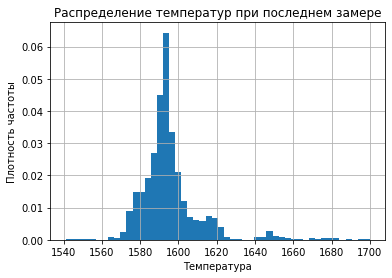

In [19]:
temp.last_temp.hist(density = True, bins = 50)
plt.title('Распределение температур при последнем замере')
plt.xlabel('Температура')
plt.ylabel('Плотность частоты');

Распределение температур при последнем измерении отдаленно напоминает нормальное (с медианным и средним значениями на уровне 1593 - 1595 градусов), но есть довольно много аномальных значений, сильно отклоняющихся от среднего в большую сторону.

Температура плавления стали: 1450—1520 °C.
(Источник: <a href = 'https://ru.wikipedia.org/wiki/%D0%A1%D1%82%D0%B0%D0%BB%D1%8C'>Википедия</a>)

Поэтому значения на уровне 1200 °C - явная аномалия.

А слишком высокие значения температур могут указывать на то, что металлургический комбинат потребляет больше электроэнергии, чем этого требует технологический процесс.

Изучим аномально низкие значения:

In [20]:
temp[(temp.first_temp < 1500)]

,key,first_temp,last_temp,iters
855,867,1191,1599,5
1201,1214,1208,1591,15
1604,1619,1218,1590,4
2036,2052,1227,1592,4


В этих наблюдениях при первом измерении температура аномально низкая. Стоит уточнить у представителей заказчика, с чем это может быть связано. Возможно, имели место какие-то нарушения технологического процесса. Составим баг-репорт, сохранив номера партий, время замеров и значения температур:

In [21]:
anomal_low = data_temp[data_temp.key.isin([867, 1214, 1619, 2052])]
# anomal_low.to_csv('Партии с аномально низкими температурами при первом замере.csv')

Удалим аномалии из датасета:

In [22]:
temp.drop(temp[temp.key.isin([867, 1214, 1619, 2052])].index, inplace = True)

С аномально высокими значениями температур ситуация чуть сложнее. Их довольно много, и чтобы решить, что с ними делать, нужно больше информации.

Для начала изучим распределение температур с помощью "ящика с усами" и посмотрим, какие значения можно считать выбросами:

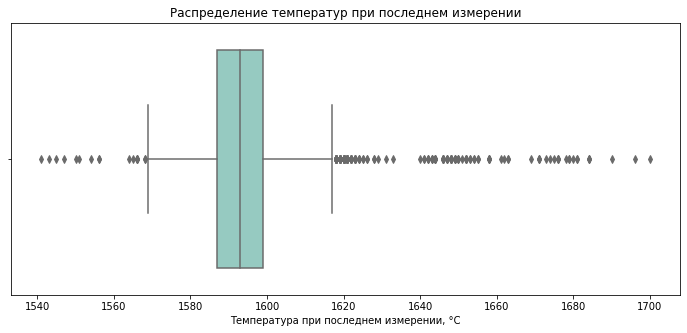

In [23]:
plt.figure(figsize = (12, 5))
sns.boxplot(temp['last_temp'], palette = 'Set3').set(xlabel = 'Температура при последнем измерении, °C')
plt.title('Распределение температур при последнем измерении');

Обычно выбросами считают значения, отклоняющиеся от первого и третьего квартилей на 1,5 межквартильных размаха:

In [24]:
q1 = np.quantile(temp['last_temp'], 0.25)
q3 = np.quantile(temp['last_temp'], 0.75)

iqr = q3 - q1

temp_max = q3 + 1.5 * iqr
temp_min = q1 - 1.5 * iqr
print('Верхняя граница:', temp_max)
print('Нижняя граница:', temp_min)

Верхняя граница: 1617.0
Нижняя граница: 1569.0


Проиндексируем датасет по номерам партий и сохраним партии, в которых температура при последнем измерении была аномально высокой или аномально низкой, в переменную `outliers`.

После объединения данных из всех файлов вернемся к анализу выбросов и примем решение, как лучше с ними поступить.

In [25]:
temp.set_index('key', inplace = True)
temp

,first_temp,last_temp,iters
key,,,
1,1571,1613,4
2,1581,1602,5
3,1596,1599,4
4,1601,1625,2
5,1576,1602,1
...,...,...,...
2495,1570,1591,2
2496,1554,1591,3
2497,1571,1589,1


In [26]:
outliers = temp[(temp.last_temp < temp_min) | (temp.last_temp > temp_max)].index
len(outliers)

195

### Данные об электродах и продувке сплава газом<a id = 'arc_gas'>

Изучим данные в файлах:
    - data_arc.csv — данные об электродах;
    - data_gas.csv — данные о продувке сплава газом.

In [27]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

Начнем с файла с данными об электродах:

In [28]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


Сразу заметно, что количество наблюдений о нагреве дугой и мощности электродов не всегда совпадает с количеством измерений температуры (в рамках одной и той же партии). Вероятно, нужно будет использовать некий усредненный показатель для каждой партии.

Для расчета потребления энергии можно использовать показатель активной мощности или высчитать значение полной мощности на основе двух показателей: активной и реактивной мощности. Попробуем использовать оба признака.

Изучим общую информацию о датасете:

In [29]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков в этом файле нет. Приведем даты к формату Datetime:

In [30]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

Проверим данные на дубликаты:

In [31]:
data_arc.duplicated().sum()

0

Высчитаем время нагрева и полную мощность.

In [32]:
data_arc['time'] = pd.TimedeltaIndex(data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).seconds
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57


Полная мощность рассчитывается как квадратный корень из суммы квадратов активной и реактивной мощностей.

In [33]:
data_arc['capacity'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
data_arc['power'] = data_arc['capacity'] * data_arc['time']
data_arc['act_power'] = data_arc['Активная мощность'] * data_arc['time']
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,capacity,power,act_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,272.149755,222.541395
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,177.416785,149.037310
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,154.118502,128.030509
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,719.221394,605.667332
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,119.471318,102.527702
...,...,...,...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157,0.640648,100.581755,83.786125
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180,0.855559,154.000682,121.788672
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184,0.874560,160.919002,135.037503
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57,0.264489,15.075853,12.579555


Сгруппируем данные по партиям и для каждой партии высчитаем суммарное потребление энергии на основе полной мощности (`power`) и активной мощности (`act_power`):

In [34]:
arc = data_arc.groupby('key').agg({'power': sum, 'act_power': sum}).reset_index()
arc.set_index('key', inplace = True)
arc

,power,act_power
key,,
1,1442.377754,1207.804249
2,881.233565,733.816470
3,525.066777,443.583327
4,796.911309,670.663327
5,1199.137958,997.496095
...,...,...
3237,958.336236,777.993447
3238,555.867370,432.849310
3239,1013.067719,844.977151


Теперь изучим данные о продувке сплава газом:

In [35]:
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [36]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [37]:
data_gas['key'].nunique()

3239

Продувка инертным газом применяется для корректировки химического состава и температуры стали. Все значения в стоблце `key` уникальны: каждой партии соответствует одно значение в столбце `Газ 1`: это количество инертного газа, использованного для продувки сплава в процессе обработки.

Проиндексируем датасет по номерам партий и переименуем столбцы для удобства дальнейшей работы:

In [38]:
gas = data_gas.set_index('key')
gas.columns = ['gas']
gas

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


### Данные о подаче сыпучих и проволочных материалов<a id = 'bulk_wire'>

Теперь изучим данные о подаче сыпучих и проволочных материалов.

Загрузим данные о сыпучих материалах:

In [39]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [40]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [41]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [42]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В некоторых столбцах всего несколько наблюдений; вряд ли они будут полезны для обучения моделей. 

Используем в качестве признаков те столбцы, в которых присутствуют данные хотя бы для половины партий, а данные в остальных столбцах просуммируем.

In [43]:
bulks = []
for i in data_bulk.columns:
    if data_bulk[i].count() > (len(data_bulk) * 0.5):
        bulks.append(i)
bulks

['key', 'Bulk 12', 'Bulk 14', 'Bulk 15']

In [44]:
data_bulk['others'] = data_bulk.loc[:, ~data_bulk.columns.isin(bulks)].sum(axis = 1)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,others
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,43.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,73.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,34.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,81.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,170.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,126.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,114.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,26.0


In [45]:
bulks.append('others')
bulk = data_bulk[bulks]
bulk.columns = ['key', 'bulk_12', 'bulk_14', 'bulk_15', 'bulk_others']
bulk

,key,bulk_12,bulk_14,bulk_15,bulk_others
0,1,206.0,150.0,154.0,43.0
1,2,206.0,149.0,154.0,73.0
2,3,205.0,152.0,153.0,34.0
3,4,207.0,153.0,154.0,81.0
4,5,203.0,151.0,152.0,78.0
...,...,...,...,...,...
3124,3237,252.0,130.0,206.0,170.0
3125,3238,254.0,108.0,106.0,126.0
3126,3239,158.0,270.0,88.0,114.0
3127,3240,NaN,192.0,54.0,26.0


Пропуски заменим нулями:

In [46]:
bulk = bulk.fillna(0)

Проиндексируем по номерам партий, как и остальные датасеты:

In [47]:
bulk.set_index('key', inplace = True)
bulk

,bulk_12,bulk_14,bulk_15,bulk_others
key,,,,
1,206.0,150.0,154.0,43.0
2,206.0,149.0,154.0,73.0
3,205.0,152.0,153.0,34.0
4,207.0,153.0,154.0,81.0
5,203.0,151.0,152.0,78.0
...,...,...,...,...
3237,252.0,130.0,206.0,170.0
3238,254.0,108.0,106.0,126.0
3239,158.0,270.0,88.0,114.0


Загрузим данные о проволочных материалах:

In [48]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [49]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В столбцах `Wire 1` и `Wire 2` достаточно много данных, в остальных столбцах почти одни пропуски. 

Используем `Wire 1` и `Wire 2` в качестве признаков, а остальные столбцы опустим.

In [52]:
wire = data_wire[['key', 'Wire 1', 'Wire 2']]
wire.columns = ['key', 'wire_1', 'wire_2']
wire = wire.fillna(0)
wire.set_index('key', inplace = True)
wire

,wire_1,wire_2
key,,
1,60.059998,0.00000
2,96.052315,0.00000
3,91.160157,0.00000
4,89.063515,0.00000
5,89.238236,9.11456
...,...,...
3237,38.088959,0.00000
3238,56.128799,0.00000
3239,143.357761,0.00000


### Объединение данных в единый датасет<a id = 'join'>

В разных файлах представлены данные о разном количестве партий. 

При объединении данных в единый датасет будем ориентироваться на файл с целевым признаком (`temp`): нам интересны те партии, которые вошли в этот датасет. 

В итоговой таблице не должно быть пропусков, поэтому используем объединение типа "inner".

Используем метод .join, чтобы объединить сразу несколько датасетов по индексу (мы проиндексировали все таблицы по номеру партии).

In [53]:
temp.shape, arc.shape, gas.shape, bulk.shape, wire.shape

((2471, 3), (3214, 2), (3239, 1), (3129, 4), (3081, 2))

In [54]:
data = temp.join(arc, how = 'inner').join(gas, how = 'inner').\
            join(bulk, how = 'inner').join(wire, how = 'inner')
data

,first_temp,last_temp,iters,power,act_power,gas,bulk_12,bulk_14,bulk_15,bulk_others,wire_1,wire_2
key,,,,,,,,,,,,
1,1571,1613,4,1442.377754,1207.804249,29.749986,206.0,150.0,154.0,43.0,60.059998,0.00000
2,1581,1602,5,881.233565,733.816470,12.555561,206.0,149.0,154.0,73.0,96.052315,0.00000
3,1596,1599,4,525.066777,443.583327,28.554793,205.0,152.0,153.0,34.0,91.160157,0.00000
4,1601,1625,2,796.911309,670.663327,18.841219,207.0,153.0,154.0,81.0,89.063515,0.00000
5,1576,1602,1,1199.137958,997.496095,5.413692,203.0,151.0,152.0,78.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570,1591,2,778.818234,626.167357,7.125735,256.0,129.0,223.0,111.0,89.150879,0.00000
2496,1554,1591,3,875.261419,727.868032,9.412616,256.0,129.0,226.0,185.0,114.179527,0.00000
2497,1571,1589,1,556.930349,427.535518,6.271699,230.0,124.0,226.0,85.0,94.086723,9.04800


### Работа с выбросами<a id = outliers>

Теперь вернемся к выбросам по значению целевого признака. 

Сравним значения признаков по партиям с аномальными значениями температур с значениями тех же признаков в остальном датасете:

In [55]:
data[data.index.isin(outliers)].describe()

,first_temp,last_temp,iters,power,act_power,gas,bulk_12,bulk_14,bulk_15,bulk_others,wire_1,wire_2
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,1601.477876,1612.938053,5.061947,1473.259680,1178.780557,14.738254,275.628319,168.345133,154.424779,183.663717,119.882023,12.914076
std,26.827191,23.164506,2.257065,841.372787,669.462642,8.372207,171.907377,89.347413,82.262407,217.518949,60.071892,30.664272
min,1530.000000,1541.000000,1.000000,69.501930,56.940238,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1586.000000,1618.000000,3.000000,923.478056,725.676023,10.126385,204.000000,106.000000,106.000000,92.000000,89.063515,0.000000
50%,1601.000000,1620.000000,5.000000,1337.918153,1092.172393,13.430307,312.000000,198.000000,203.000000,118.000000,121.165196,0.000000
75%,1622.000000,1622.000000,6.000000,1908.122475,1519.280682,17.407262,412.000000,221.000000,205.000000,173.000000,160.009209,0.000000
max,1658.000000,1653.000000,14.000000,5123.890430,4114.814680,52.142373,570.000000,417.000000,337.000000,1276.000000,249.958786,170.886566


In [56]:
data.drop(data[data.index.isin(outliers)].index).describe()

,first_temp,last_temp,iters,power,act_power,gas,bulk_12,bulk_14,bulk_15,bulk_others,wire_1,wire_2
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000
mean,1586.644213,1592.366184,3.924051,909.736627,697.955499,11.207332,205.079114,153.237342,118.269439,124.587251,101.519752,17.845305
std,23.225372,9.182441,1.738858,1758.874556,501.970659,6.231996,155.612624,80.924672,84.438308,103.405343,42.343740,33.776894
min,1519.000000,1569.000000,1.000000,15.158096,10.614857,0.016696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1571.000000,1587.000000,3.000000,459.834382,361.645637,7.223968,105.000000,105.000000,0.000000,60.000000,72.467460,0.000000
50%,1586.000000,1592.000000,4.000000,750.347367,594.948959,9.979763,206.000000,149.000000,106.000000,106.000000,100.198799,0.000000
75%,1602.000000,1597.000000,5.000000,1124.406543,897.466964,13.966174,262.250000,203.000000,204.000000,165.000000,126.898206,23.645440
max,1660.000000,1617.000000,15.000000,78179.108228,8624.443403,77.995040,1849.000000,636.000000,405.000000,1111.000000,330.314424,282.780152


Как видим, распределение многих признаков по наблюдениям с аномальными температурами сильно отличается от их распределения по остальному датасету. 

Большинство аномалий отличается от стандартных значений температуры в большую сторону. Можно предположить, что это ошибки измерений, но это не так: среднее потребление энергии, расход сыпучих и проволочных материалов и инертного газа для наблюдений с аномальными температурами заметно выше, чем в остальном датасете.

Если мы избавимся от этих аномальных значений, наша модель будет показывать более высокое качество на этапе обучения. Но в реальных условиях она не будет справляться с предсказанием температур, сильно отличающихся от стандартных. А таких аномалий немало (почти 5% нашего датасета). 

Поэтому оставим наблюдения с аномальными значениями температур, чтобы повысить предсказательную способность модели на реальных данных.

Стоит избавиться от явной аномалии в столбце `power`:

In [57]:
data[data.power > 11000]

,first_temp,last_temp,iters,power,act_power,gas,bulk_12,bulk_14,bulk_15,bulk_others,wire_1,wire_2
key,,,,,,,,,,,,
2116,1579,1578,3,78179.108228,210.692117,11.582547,0.0,198.0,0.0,137.0,75.216965,0.0


In [58]:
data_arc[data_arc.key == 2116]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,time,capacity,power,act_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141,122,0.530511,64.722344,52.858492
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352,135,0.742616,100.253208,83.735708
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109,715.505096,77990.055458,54.040292
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796,67,0.359361,24.077217,20.057626


In [59]:
data.drop(data[data.index == 2116].index, inplace = True)

### Корреляция признаков<a id = 'correlation'>

Выясним, как коррелируют признаки, чтобы избежать мультиколлинеарности, которая может привести к переобучению моделей машинного обучения. Сформируем и визуализируем матрицу корреляции:

In [60]:
data.corr()

,first_temp,last_temp,iters,power,act_power,gas,bulk_12,bulk_14,bulk_15,bulk_others,wire_1,wire_2
first_temp,1.000000,0.301882,0.195105,-0.416027,-0.419504,0.036736,-0.079574,-0.179991,-0.062382,0.005057,0.262880,-0.101101
last_temp,0.301882,1.000000,0.098012,0.274535,0.285103,0.059079,0.266805,0.114893,0.265772,-0.088212,0.317488,-0.207242
iters,0.195105,0.098012,1.000000,0.262908,0.257163,0.325049,0.087806,0.112237,-0.005778,0.185321,0.163912,0.050116
power,-0.416027,0.274535,0.262908,1.000000,0.996860,0.318929,0.479666,0.440723,0.308601,0.138287,0.006195,0.015829
act_power,-0.419504,0.285103,0.257163,0.996860,1.000000,0.318624,0.479713,0.443950,0.315411,0.141162,0.014182,0.016506
gas,0.036736,0.059079,0.325049,0.318929,0.318624,1.000000,0.216969,0.268284,0.043033,0.272388,0.118192,0.104653
bulk_12,-0.079574,0.266805,0.087806,0.479666,0.479713,0.216969,1.000000,0.481609,0.613870,0.011522,0.170812,-0.098208
bulk_14,-0.179991,0.114893,0.112237,0.440723,0.443950,0.268284,0.481609,1.000000,0.264903,0.011835,-0.052654,0.037017
bulk_15,-0.062382,0.265772,-0.005778,0.308601,0.315411,0.043033,0.613870,0.264903,1.000000,-0.069568,0.119047,-0.096411
bulk_others,0.005057,-0.088212,0.185321,0.138287,0.141162,0.272388,0.011522,0.011835,-0.069568,1.000000,-0.010421,0.011733


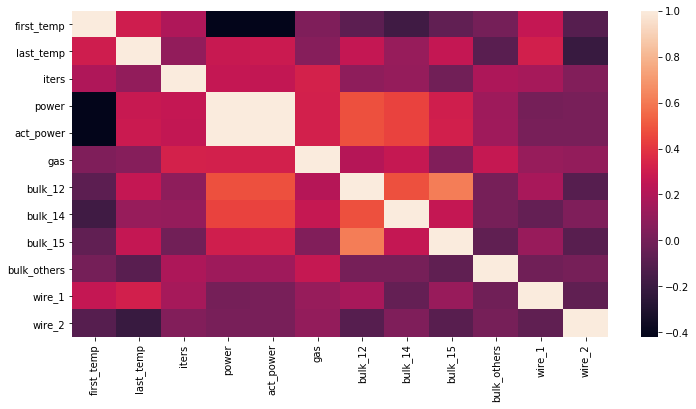

In [61]:
plt.figure(figsize = (12, 6))
sns.heatmap(data.corr());

Довольно высокая корреляция (0.614) заметна между `bulk_12` и `bulk_15`. В обоих столбцах примерно одинаковое количество данных, и корреляция этих признаков с целевым признаком примерно на одном уровне. Пока оставим оба признака; при необходимости удалим один из них.

Также существует сильная линейная взаимосвязь между `act_power` и `power`; избавимся от одного из признаков:

In [62]:
data = data.drop('power', axis = 1)

# Обучение моделей, выбор лучшей модели<a id="models"></a>

### Подготовка данных к машинному обучению<a id = 'pre_ML'>

Импортируем библиотеки:

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [64]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [65]:
from datetime import datetime as dt

Подготовим датасет к обучению моделей. Выделим целевой признак и признаки для обучения:

In [66]:
X = data.drop(['last_temp'], axis = 1).reset_index(drop = True)
y = data['last_temp'].reset_index(drop = True)

Разделим данные на обучающую и тестовую выборки в соотношении 4:1:

In [67]:
# выделим тестовую выборку в 20% от датасета
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [68]:
X_train.shape, X_test.shape

((1859, 10), (465, 10))

Масштабируем признаки:

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

Для оценки качества моделей будем использовать **среднее абсолютное отклонение - MAE (mean absolute error)**.

## Модель линейной регрессии с регуляризацией (Lasso)<a id = 'lasso'>

Обучим модель Lasso, подберем гиперпараметры на кросс-валидации и выведем лучший MAE на кросс-валидации и MAE на тестовой выборке: 

In [70]:
start = dt.now()

lasso = Lasso()
params = {'alpha': [0.1, 0.3, 0.5, 0.7, 1]}

model_lasso = GridSearchCV(lasso, param_grid = params, scoring = 'neg_mean_absolute_error', cv = 3)
model_lasso.fit(X_train, y_train)

lasso_mae_train = mean_absolute_error(y_train, model_lasso.predict(X_train))
lasso_mae_test = mean_absolute_error(y_test, model_lasso.predict(X_test))

lasso_time = dt.now() - start

print('Лучший MAE на обучении:', round(lasso_mae_train, 4))
print('MAE на тестовой выборке:', round(lasso_mae_test, 4))
print(lasso_time)

Лучший MAE на обучении: 6.3553
MAE на тестовой выборке: 6.4535
0:00:01.315287


Оценим важность разных признаков в обученной на наших данных модели Lasso:

In [71]:
def fimp_plot(data, name):
    data.sort_values(ascending = False).plot(kind = 'bar')
    plt.title("Важность признаков в модели {}".format(name))
    plt.xlabel("Признаки")
    plt.ylabel("Важность признака")
    plt.xticks(rotation = 45);

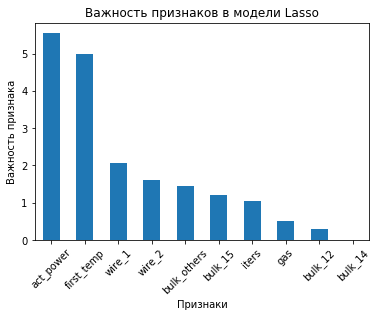

In [72]:
fimp_plot(pd.Series(abs(model_lasso.best_estimator_.coef_), index = X.columns), 'Lasso')

## Модель случайного леса (Random Forest)<a id = random_forest>

Теперь обучим модель случайного леса с подбором гиперпараметров на кросс-валидации:

In [73]:
start = dt.now()

ranfor = RandomForestRegressor(random_state = 123)
params = {'n_estimators': range(100, 501, 100)}

model_ranfor = GridSearchCV(ranfor, param_grid = params, scoring = 'neg_mean_absolute_error', cv = 3, n_jobs = -1)
model_ranfor.fit(X_train, y_train)

ranfor_mae_train = mean_absolute_error(y_train, model_ranfor.predict(X_train))
ranfor_mae_test = mean_absolute_error(y_test, model_ranfor.predict(X_test))

ranfor_time = dt.now() - start

print('Лучший MAE на обучении:', round(ranfor_mae_train, 4))
print('MAE на тестовой выборке:', round(ranfor_mae_test, 4))
print(ranfor_time)

Лучший MAE на обучении: 2.2834
MAE на тестовой выборке: 6.1732
0:00:42.814911


Посмотрим, какие признаки получили наибольшее значение в модели случайного леса:

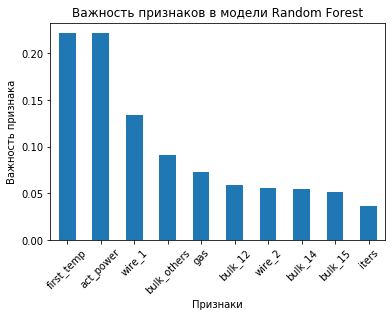

In [74]:
fimp_plot(round(pd.Series(model_ranfor.best_estimator_.feature_importances_, index = X_train.columns), 4), 'Random Forest')

## Модель градиентного бустинга (LightGBM)<a id = 'lgbm'>

Теперь используем градиентный бустинг с подбором параметра скорости обучения и количества деревьев:

In [75]:
start = dt.now()

gbm = LGBMRegressor(random_state = 123, importance_type = 'gain')
params = {'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': [600, 700]}

model_gbm = GridSearchCV(gbm, param_grid = params, scoring = 'neg_mean_absolute_error', cv=3, n_jobs = -1)
model_gbm.fit(X_train, y_train)

gbm_mae_train = mean_absolute_error(y_train, model_gbm.predict(X_train))
gbm_mae_test = mean_absolute_error(y_test, model_gbm.predict(X_test))

gbm_time = dt.now() - start

print('Лучший MAE на обучении:', round(gbm_mae_train, 4))
print('MAE на тестовой выборке:', round(gbm_mae_test, 4))
print(gbm_time)

Лучший MAE на обучении: 3.7612
MAE на тестовой выборке: 6.1294
0:00:19.166856


Оценим важность признаков по версии модели LightGBM:

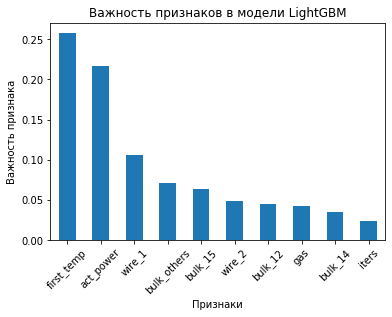

In [76]:
fimp_plot(round(pd.Series(model_gbm.best_estimator_.feature_importances_/10000000, index = X_train.columns), 4), 
'LightGBM')

## Модель градиентного бустинга (Catboost)<a id = 'catboost'>

Обучим модель градиентного бустинга Catboost и подберем гиперпараметры:

In [77]:
start = dt.now()

cat = CatBoostRegressor()

params = {'learning_rate': [0.1, 0.15], 'depth': [4, 8], 
          'loss_function': ['MAE'], 'iterations': [300], 'random_seed': [123]}

catboost = GridSearchCV(cat, param_grid=params, scoring = 'neg_mean_absolute_error', cv=3, n_jobs = -1)
catboost.fit(X_train, y_train, verbose = False)

catboost_mae_train = mean_absolute_error(y_train, catboost.predict(X_train))
catboost_mae_test = mean_absolute_error(y_test, catboost.predict(X_test))

catboost_time = dt.now() - start

print('Лучший MAE на обучении:', round(catboost_mae_train, 4))
print('MAE на тестовой выборке:', round(catboost_mae_test, 4))
print(catboost_time)

Лучший MAE на обучении: 4.1862
MAE на тестовой выборке: 5.8357
0:01:22.578360


Посмотрим, какие признаки получили приоритет в модели Catboost:

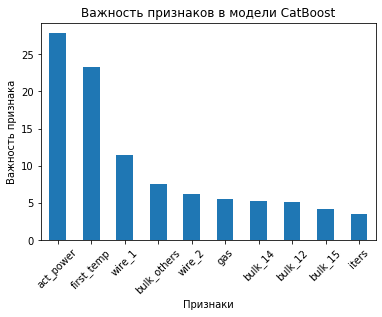

In [78]:
fimp_plot(round(pd.Series(catboost.best_estimator_.feature_importances_, index = X_train.columns), 4), 
'CatBoost')

### Сравнение моделей и выбор лучшей модели<a id = 'best_model'>

Сравним показатели разных моделей:

In [79]:
results = [['Lasso', lasso_mae_train, lasso_mae_test, lasso_time], ['Random Forest', ranfor_mae_train, ranfor_mae_test, ranfor_time],  \
           ['LightGBM', gbm_mae_train, gbm_mae_test, gbm_time], ['Catboost', catboost_mae_train, catboost_mae_test, catboost_time]]
table = pd.DataFrame(results, columns = ['Model', 'MAE (cv)', 'MAE (test)', 'Time'])
table

,Model,MAE (cv),MAE (test),Time
0,Lasso,6.355326,6.453532,00:00:01.315287
1,Random Forest,2.283416,6.173213,00:00:42.814911
2,LightGBM,3.761186,6.129432,00:00:19.166856
3,Catboost,4.186204,5.835652,00:01:22.578360


Модель Lasso обучается очень быстро, но показывает не лучший результат. 

RandomForest даёт MAE ниже, но обучается дольше.

Лучший результат показала модель Catboost: самый низкий MAE при достаточно высокой скорости обучения.

Наиболее удачные модели отдали приоритет одним и тем же признакам, в порядке убывания важности:
    
    - температура при первом измерении;
    - энергопотребление, рассчитанное на основе активной мощности;
    - показатели wire_1 и bulk_others.

# Выводы по проекту<a id="summary"></a>

- Проведена предобработка данных. В файле `data_temp.csv` с результатами измерения температур много пропущенных значений (более 18% наблюдений), а также есть несколько аномально низких значений температур при первом измерении. 

Составлены *баг-репорты* для заказчика для выявления причин и устранения возможных ошибок при сборе данных.


- Обнаружено также большое количество выбросов, где целевой признак (температура стали при последнем измерении) сильно превышает стандартные значения. Судя по всему, в рамках технологического процесса подобные аномалии возникают довольно часто (около 5% партий), поэтому от них решено было не избавляться. 

Включение таких отклоняющихся значений в обучающую выборку позволит повысить предсказательную способность модели машинного обучения на реальных данных.


- Сгенерированы дополнительные признаки для обучения моделей. В том числе, температура при первом измерении, количество итераций, энергопотребление с учетом времени нагрева и мощности электродов (отдельно для активной мощности и полной мощности), суммарный объем сыпучих материалов (по данным из нескольких столбцов таблицы `data_bulk`).


- Протестировано несколько алгоритмов машинного обучения, для каждой модели подобраны гиперпараметры на кросс-валидации. Выбрана оптимальная модель по критерию качества (*MAE*) и скорости обучения.

Среди моделей Lasso, Random Forest, Light GBM и Catboost наилучший результат показала модель Catboost. **MAE на тестовой выборке - 5.835**.


- В результате проведенного анализа важности признаков выяснилось, что наиболее эффективные модели отдали приоритет одним и тем же признакам (в порядке убывания важности):

температура при первом измерении, энергопотребление (на основе активной мощности), показатели `wire_1` и `bulk_others`.


- Таким образом, в результате работы над проектом удалось обучить модель, которая может с высокой точностью предсказывать температуру стали. Это позволит решить задачу заказчика: уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы.